# PROYECTO FINAL

La empresa GoGreen Bikesharing se dedica al alquiler de bicicletas y posee datos tales como la cantidad de bicis alquiladas por usuarios registrados, la cantidad de alquileres realizados por usuarios puntuales, y la cantidad total. 

A estos datos se les añadió información meteorológica y el calendario de festivos.

Ahora buscan analizar cuáles son los aspectos que más influyen en la cantidad de bicis que van a alquilar en un día.

In [1]:
# Tratamiento de datos
import numpy as np
import pandas as pd
#import sidetable as stb

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import sidetable as stb

# Asunciones y Preprocesamiento
from scipy import stats
import math
from scipy.stats import levene
#import researchpy as rp
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import researchpy as rp # chi square

#Linear Regresion con Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = False

    Leer CSV

- <font color = violet> NO TENEMOS NULOS
-  730 filas
- 17 columnas
- **Holiday** : 1 = festivo / 0 = no festivo
- **Weekday** = 0 Domingo - 6 Sábado
- **Workingday** = 1 laborable / 0 finde
- **Weathersit** = grados en el readme
- **Temperatura** = 
- **Humedad** =
- **Viento** = 
- **Casual** = nº de usuarios no registrados/día
- **Registered** = nº de usuarios registrados/día
- **Total** = total de usuarios/día


In [2]:
df_bike = pd.read_csv("./bikes.csv", index_col=0)
df_bike.sample(6)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
67,68,09-03-2018,spring,0,3,0,3,1,2,12.129153,14.33040,77.5417,14.750050,191,1700,1891
90,91,01-04-2018,summer,0,4,0,5,1,2,12.300000,14.17270,68.6250,17.333436,307,1920,2227
706,707,08-12-2019,winter,1,12,0,6,0,2,15.648347,19.47540,91.1250,6.792393,1153,4429,5582
477,478,23-04-2019,summer,1,4,0,1,1,2,13.188347,15.05625,76.6667,20.334232,195,3019,3214
272,273,30-09-2018,winter,0,9,0,5,1,1,23.130847,27.24145,64.7500,13.833825,830,4372,5202
485,486,01-05-2019,summer,1,5,0,2,1,2,25.146653,28.85105,65.9583,10.458432,653,5087,5740


---------

In [3]:
df_bike.describe()

,instant,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [4]:
df_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(2)
memory usage: 97.0+ KB


# REVISIÓN DE COLUMNAS:

### 1. FECHA:
- Tenemos "yr" (año) y "mnth" (mes) y obtenemos "day" a través de la separación de "dteday", que posteriormente eliminaremos:

In [5]:
df_bike["day"] = df_bike["dteday"].str.split(pat= "-", n = -1, expand = True)[0]

In [6]:
df_bike=df_bike.reindex(columns=['instant', 'dteday', 'season', 'yr', 'mnth','day', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'])

In [7]:
df_bike.head()

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,01,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,02,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,03,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,04,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,05,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


------

### 2. Columna "season"
- Corregir de acuerdo con las fechas.

In [8]:
df_bike['dteday'] = df_bike['dteday'].apply(pd.to_datetime)

In [9]:
def meses(x):
    a = x.month

    if  a >= 1 and a<=3:
        return 'winter'
    elif a >= 4 and a<=6:
        return 'spring'
    elif a >= 7 and a<=9:
        return 'summer'
    else:
        return 'autumn'

In [10]:
df_bike['season'] = df_bike['dteday'].apply(meses)

In [11]:
df_bike.sample(5)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
128,129,2018-09-05,summer,0,5,09,0,1,1,1,21.832500,26.26230,58.8750,11.792000,664,3698,4362
651,652,2019-10-14,autumn,1,10,14,0,0,0,1,21.388347,25.41020,64.0417,18.667004,2080,4559,6639
354,355,2018-12-21,autumn,0,12,21,0,3,1,2,17.561653,21.40085,85.8333,14.833800,107,2553,2660
274,275,2018-02-10,winter,0,10,02,0,0,0,2,14.623347,17.26585,79.1667,14.874871,616,2302,2918
667,668,2019-10-30,autumn,1,10,30,0,2,1,2,13.045462,15.49545,82.5455,14.271603,87,1009,1096


 - Antes de codificarla hacemos una gráfica para ver cómo se reparte el alquiler de bicicletas durante las estaciones.

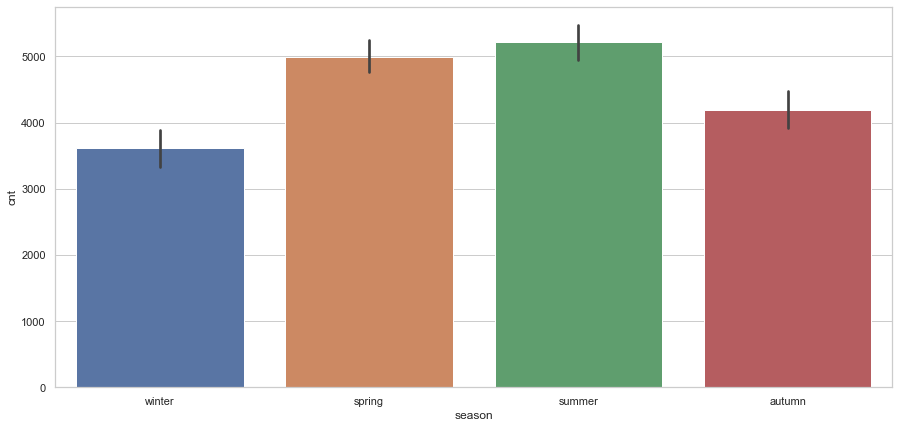

In [12]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
ax = sns.barplot(x = "season", y="cnt", data= df_bike)

 - Encoding numérico para la columna season

In [13]:
scale_mapper = {"winter":1, "spring":1, "summer":2, 'autumn':3}

df_bike['season_encoding'] = df_bike["season"].replace(scale_mapper)

- Hacemos una pequeña exploración preliminar con "season": ¿Cuántas reservas se hacen por estación y por tipo de cliente?

In [14]:
x= df_bike.groupby(['season']).agg({'cnt': ['sum'],'casual': ['sum'],'registered': ['sum']}).stb.subtotal()
x

,cnt,casual,registered
,sum,sum,sum
season,,,
autumn,771700,128069,643631
spring,909613,192850,716763
summer,958925,187579,771346
winter,650607,111454,539153
grand_total,3290845,619952,2670893


<AxesSubplot:xlabel='registered', ylabel='season'>

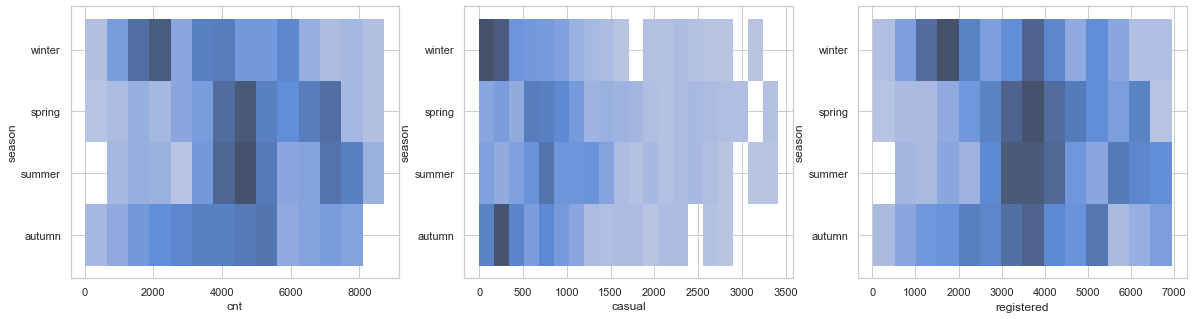

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.histplot(data=df_bike, x="cnt",y="season",ax=axes[0])
sns.histplot(data=df_bike, x="casual",y="season",ax=axes[1])
sns.histplot(data=df_bike, x="registered",y="season",ax=axes[2])

#HAY MAS RESERVAS DE GENTE REGISTRADA QUE CASUAL

--------

### 3. Columna "year" 

In [16]:
#df_bike['yr'].stb.subtotal()

y_= df_bike.groupby(['yr']).agg({'cnt': ['sum'],'casual': ['sum'],'registered': ['sum']}).stb.subtotal()
y_

,cnt,casual,registered
,sum,sum,sum
yr,,,
0,1243103,247252,995851
1,2047742,372700,1675042
grand_total,3290845,619952,2670893


([<matplotlib.axis.XTick at 0x7f964ed424c0>,
 [Text(0, 0, '2018'), Text(1, 0, '2019')])

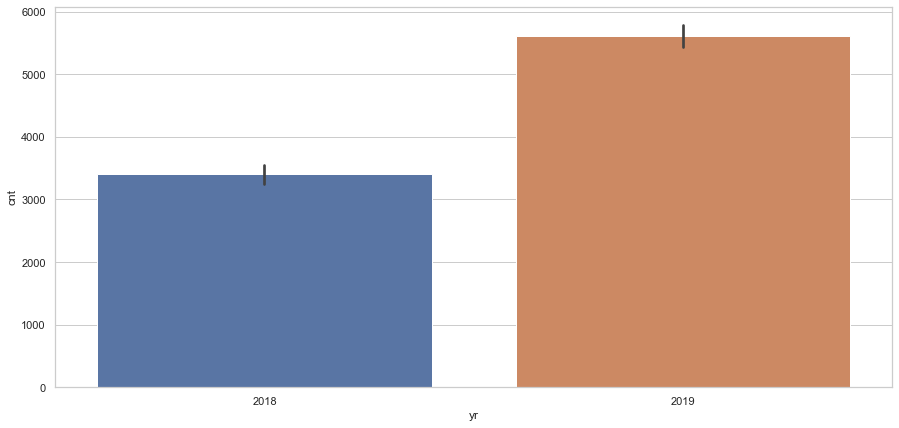

In [17]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "yr", y="cnt", data= df_bike)
plt.xticks([0, 1], ["2018", "2019"])

----

### 4. "Month" -> Exploración preliminar: reservas por mes.

<AxesSubplot:xlabel='mnth', ylabel='casual'>

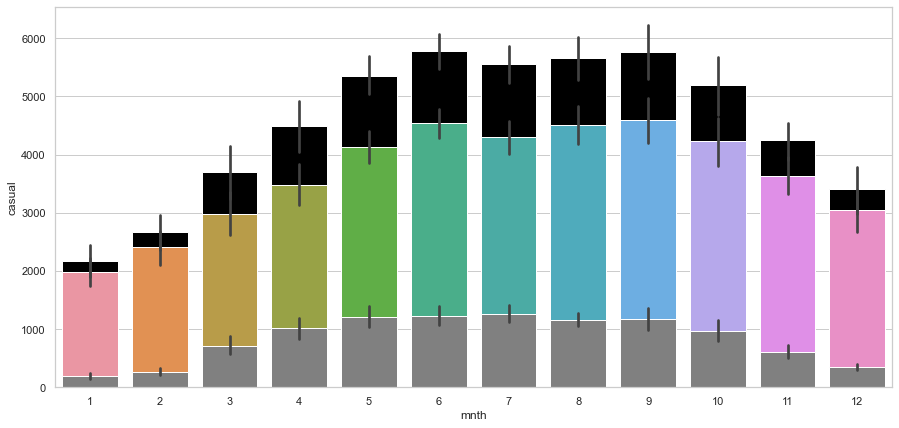

In [18]:
plt.figure(figsize=(15,7))
sns.set_theme(style= "whitegrid")
sns.barplot(x = "mnth", y ="cnt", data= df_bike, color = "black")

sns.barplot(x = "mnth", y="registered", data= df_bike)
sns.barplot(x = "mnth", y="casual", data= df_bike, color = "grey")
#plt.xticks([0, 1], ["2018", "2019"])

----

### 5. "Holiday"
1 = festivo /  0 = no festivo

df_bike.groupby(["holiday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)


Observamos: 
- Más reservas en NO FESTIVOS
- HAY MAYOR NUMERO DE RESERVAS LOS NO FESTIVOS
- Además:
    - SUMA EN NO FESTIVO
         - REGISTRADOS 2.614.817 RESERVAS EN NO FESTIVO
         - CASUAL 597.593 RESERVAS EN NO FESTIVO

    - SUMA EN FESTIVO
        - REGISTRADOS 56.076 RESERVAS EN  FESTIVO
        - CASUAL 22.359 RESERVAS EN NO FESTIVO

<AxesSubplot:xlabel='holiday', ylabel='count'>

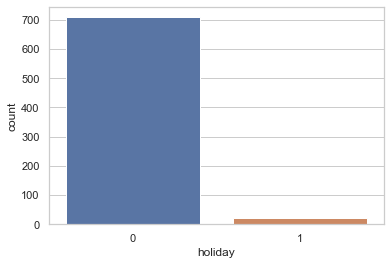

In [19]:
sns.countplot(x='holiday', data=df_bike)

-----

### 6. "Weekday" 
- 1-LUNES / 2-MARTES / 3-MIERCOLES / 4- JUEVES / 5-VIERNES / 6-SÁBADO / 0 -DOMINGO 

     Hay bastante igualdad entre los dias de la semana, siendo el ranking de más a menos reservas:
     ORDEN DE DIAS POR RESERVA: Viernes, jueves,sabado, miercoles,martes,lunes y domingo.


In [20]:
df_bike.groupby(["weekday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)

cnt                      ... registered                     
                min      max        sum  ...        max        sum      mean
weekday                                  ...                                
0             605.0   8227.0   444027.0  ...     5657.0   303506.0   2890.53
1              22.0   7525.0   455503.0  ...     6435.0   384719.0   3663.99
2             683.0   7767.0   469109.0  ...     6697.0   411266.0   3954.48
3             441.0   8173.0   471214.0  ...     6946.0   413960.0   4019.03
4             431.0   7804.0   485395.0  ...     6781.0   423935.0   4076.30
5            1167.0   8362.0   487790.0  ...     6917.0   409552.0   3938.00
6             627.0   8714.0   477807.0  ...     5966.0   323955.0   3085.29
grand_total  3976.0  56572.0  3290845.0  ...    45399.0  2670893.0  25627.62

[8 rows x 12 columns]

<AxesSubplot:xlabel='weekday', ylabel='registered'>

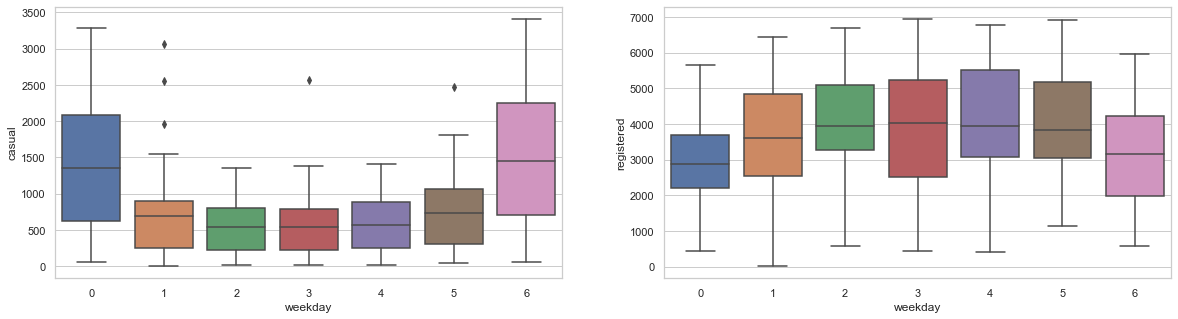

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(data=df_bike, x='weekday', y='casual',ax=axes[0])
sns.boxplot(data=df_bike, x='weekday', y='registered',ax=axes[1])

----

### 7. "workingday": 
- 1 - LABORABLE  /  0 -FIN DE SEMANA

In [22]:
df_bike.groupby(["workingday"]).agg({ 'cnt': ['min','max','sum','mean'],'casual': ['min','max','sum','mean'],'registered': ['min','max','sum','mean']}).stb.subtotal().round(2)
# 1 dia laborable - hay muchas mas reservas en días laborables que festivos, más de el doble.

cnt                      ... registered                    
               min      max        sum  ...        max        sum     mean
workingday                              ...                               
0            605.0   8714.0  1000269.0  ...     5966.0   683537.0  2959.03
1             22.0   8362.0  2290576.0  ...     6946.0  1987356.0  3982.68
grand_total  627.0  17076.0  3290845.0  ...    12912.0  2670893.0  6941.71

[3 rows x 12 columns]

---

### 8. "weathersit": 
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [23]:
weather = pd.DataFrame(df_bike[["cnt", "weathersit"]].groupby("weathersit"))

In [24]:
i = 0
lista2 = []
for i in range(len(df_bike["weathersit"].value_counts())):
    a = weather[1][i]["cnt"].sum()
    i = i+1
    lista2.append(a)

In [25]:
weathersit = pd.DataFrame(lista2)
weathersit["%"] = weathersit[0].apply(lambda x: x / df_bike.shape[0] * 100)
weathersit["Tipo"] = ["1", "2", "3"]

In [26]:
labelsX = ["1: Clear, Few clouds, Partly cloudy, Partly cloudy", "2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist", "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds"]


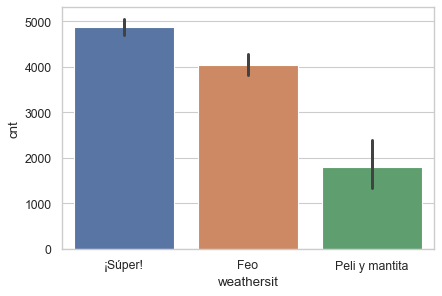

In [27]:
plt.figure(figsize=(6,4), dpi= 80)

sns.barplot(x = "weathersit", y = "cnt", data = df_bike)
plt.xticks([0, 1, 2], ["¡Súper!", "Feo", "Peli y mantita"]);


---

### 9. Temperatura, Sensación Térmica y Humedad

hay que hacer encoding con etiquetas para las graficas

In [28]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1


In [29]:
df_bike[['temp','atemp','hum']] = df_bike[['temp','atemp','hum']].round(1)

In [30]:
df_temp = df_bike[['temp','atemp']]
df_temp

,temp,atemp
0,14.1,18.2
1,14.9,17.7
2,8.1,9.5
3,8.2,10.6
4,9.3,11.5
...,...,...
725,10.4,11.3
726,10.4,12.8
727,10.4,12.1
728,10.5,11.6


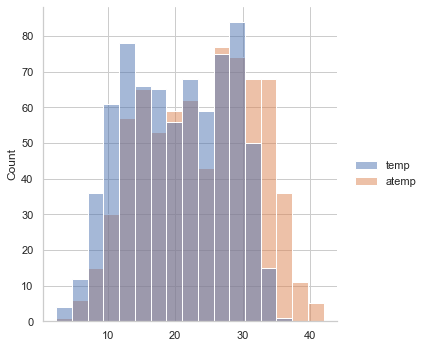

In [31]:
sns.displot(df_temp)

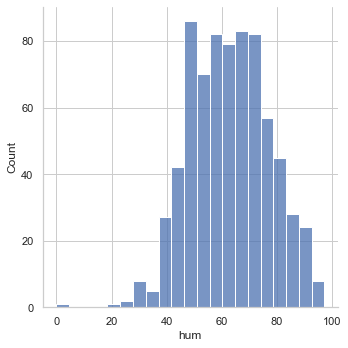

In [32]:
sns.displot(df_bike["hum"])

In [33]:
df_clima = df_bike[['temp','atemp','hum']]

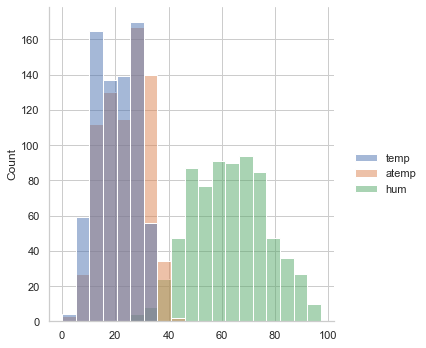

In [34]:
sns.displot(df_clima)

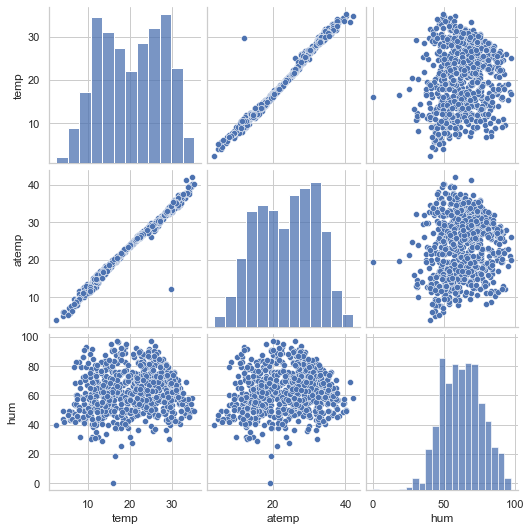

In [35]:
sns.pairplot(df_clima);

Voy a ver normalidad numéricamente

In [36]:
stats.shapiro(df_bike["atemp"])

ShapiroResult(statistic=0.9737697243690491, pvalue=3.6718658669165904e-10)

In [37]:
stats.shapiro(df_bike["temp"])

ShapiroResult(statistic=0.9657878279685974, pvalue=4.954737575085799e-12)

In [38]:
stats.shapiro(df_bike["hum"])

ShapiroResult(statistic=0.9933574795722961, pvalue=0.0025413876865059137)

Estas tres variables parecen normales

- Codificando variables

In [39]:
df_bike["temp_interval"] = pd.cut(df_bike["temp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [40]:
df_bike["temp_interval_num"] = pd.cut(df_bike["temp"], 5, ordered=True)

In [41]:
#df_bike["atemp_interval"] = pd.cut(df_bike["atemp"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [42]:
df_bike["hum_interval"] = pd.cut(df_bike["hum"], 5,labels = ["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [43]:
df_bike["hum_interval_num"] = pd.cut(df_bike["hum"], 5, ordered=True)

In [44]:
df_bike.head(2)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]"
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]"


In [45]:
#df_interval = df_bike[["atemp_interval","temp_interval","hum_interval"]]
#df_interval

Voy a hacer un ordinal encoding

In [46]:
from sklearn.preprocessing import OrdinalEncoder
orden = ["very_low", "low", "medium", "high", "very_high"]

In [47]:
def ordinal_encoder(df, columna, orden_valores):
    
    # nos creamos un diccionario vacío para hacer el map después. 
    ordinal_dict = {}
    
    # iteramos por nuestra lista de valores usando el enumerate que recordamos nos devolvía también el índice o posición de cada elemento
    for i, valor in enumerate(orden_valores):
        ordinal_dict[valor]=i+1 # le sumamos uno a la posición para no tener valores de 0. 
    
    # aplicamos el map
    df[columna+"_ord"] = df[columna].map(ordinal_dict)
    return df

In [48]:
#ordinal_encoder(df_bike, "atemp_interval", orden)

In [49]:
ordinal_encoder(df_bike, "temp_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2


In [50]:
ordinal_encoder(df_bike, "hum_interval", orden)

,instant,dteday,season,yr,mnth,day,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_encoding,temp_interval,temp_interval_num,hum_interval,hum_interval_num,temp_interval_ord,hum_interval_ord
0,1,2018-01-01,winter,0,1,01,0,6,0,2,14.1,18.2,80.6,10.749882,331,654,985,1,low,"(8.98, 15.56]",very_high,"(77.76, 97.2]",2,5
1,2,2018-02-01,winter,0,1,02,0,0,0,2,14.9,17.7,69.6,16.652113,131,670,801,1,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
2,3,2018-03-01,winter,0,1,03,0,1,1,1,8.1,9.5,43.7,16.636703,120,1229,1349,1,very_low,"(2.367, 8.98]",medium,"(38.88, 58.32]",1,3
3,4,2018-04-01,spring,0,1,04,0,2,1,1,8.2,10.6,59.0,10.739832,108,1454,1562,1,very_low,"(2.367, 8.98]",high,"(58.32, 77.76]",1,4
4,5,2018-05-01,spring,0,1,05,0,3,1,1,9.3,11.5,43.7,12.522300,82,1518,1600,1,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,2019-12-27,autumn,1,12,27,0,4,1,2,10.4,11.3,65.3,23.458911,247,1867,2114,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
726,727,2019-12-28,autumn,1,12,28,0,5,1,2,10.4,12.8,59.0,10.416557,644,2451,3095,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
727,728,2019-12-29,autumn,1,12,29,0,6,0,2,10.4,12.1,75.3,8.333661,159,1182,1341,3,low,"(8.98, 15.56]",high,"(58.32, 77.76]",2,4
728,729,2019-12-30,autumn,1,12,30,0,0,0,1,10.5,11.6,48.3,23.500518,364,1432,1796,3,low,"(8.98, 15.56]",medium,"(38.88, 58.32]",2,3


- Saco gráficos

In [51]:
df_group_temp = df_bike.groupby(["temp_interval"]).agg({'cnt': ['sum']})

In [52]:
df_group_hum= df_bike.groupby(["hum_interval"]).agg({'cnt': ['sum']})
df_group_hum

,cnt
,sum
hum_interval,
very_low,2258
low,95327
medium,1224798
high,1595145
very_high,373317


Se acercan bastante a la normal.

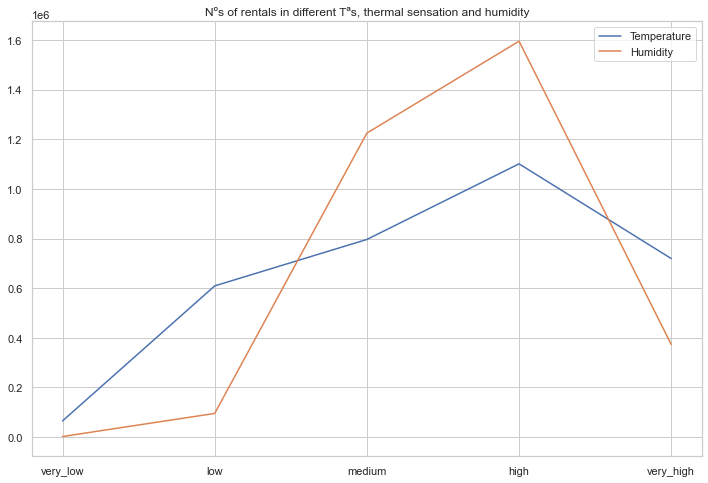

In [53]:
plt.figure(figsize=(12,8))
plt.plot(df_group_temp, label = "Temperature")
#plt.plot(df_group_atemp, label = "Thermal sensation")
plt.plot(df_group_hum, label = "Humidity")
plt.title("Nºs of rentals in different Tªs, thermal sensation and humidity")
plt.legend()
plt.show()

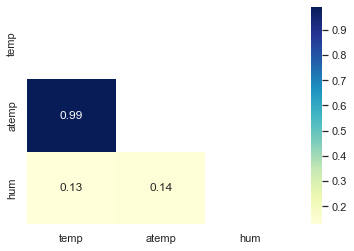

In [54]:
mask = np.triu(np.ones_like(df_clima.corr(), dtype=np.bool))
mask
sns.heatmap(df_clima.corr(),
            cmap = "YlGnBu", 
            mask = mask, # incorporamos la máscara en nuestro plot
           annot = True); 

---

### 10. "Windspeed": encoding

In [55]:
df_bike['wind_interval'] = pd.cut(df_bike['windspeed'], 5, labels=["very_low", "low", "medium", "high", "very_high"], ordered=True)

In [56]:
df_bike['wind_interval'] = df_bike['wind_interval'].astype('object')

 - Al utilizar el método pd.cut nos devuelve una columna categórica, por eso lo cambiamos a tipo int64. Ahora ya tenemos codificada esta columna.

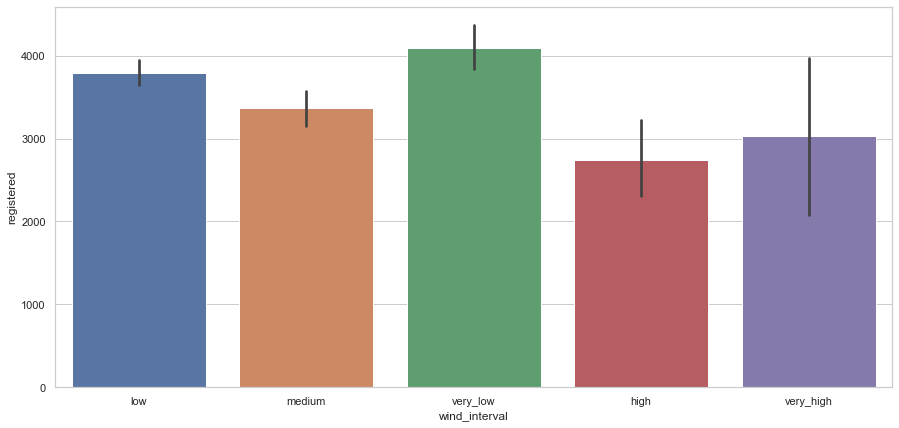

In [57]:
plt.figure(figsize=(15,7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="wind_interval", y="registered", data=df_bike)

 - Encoding numérico para la columna wind

In [58]:
scale_mapper = {"very low":0, "low":1, "medium":2, 'high':3, 'very high':4}

df_bike['wind_num_encoding'] = df_bike["wind_interval"].replace(scale_mapper)

----

### Últimas columnas: bicis registradas
- cnt (total por día)
- registered (reservadas por usuarios registrados)
- casual (bicis alquiladas por usuarios casuales) 

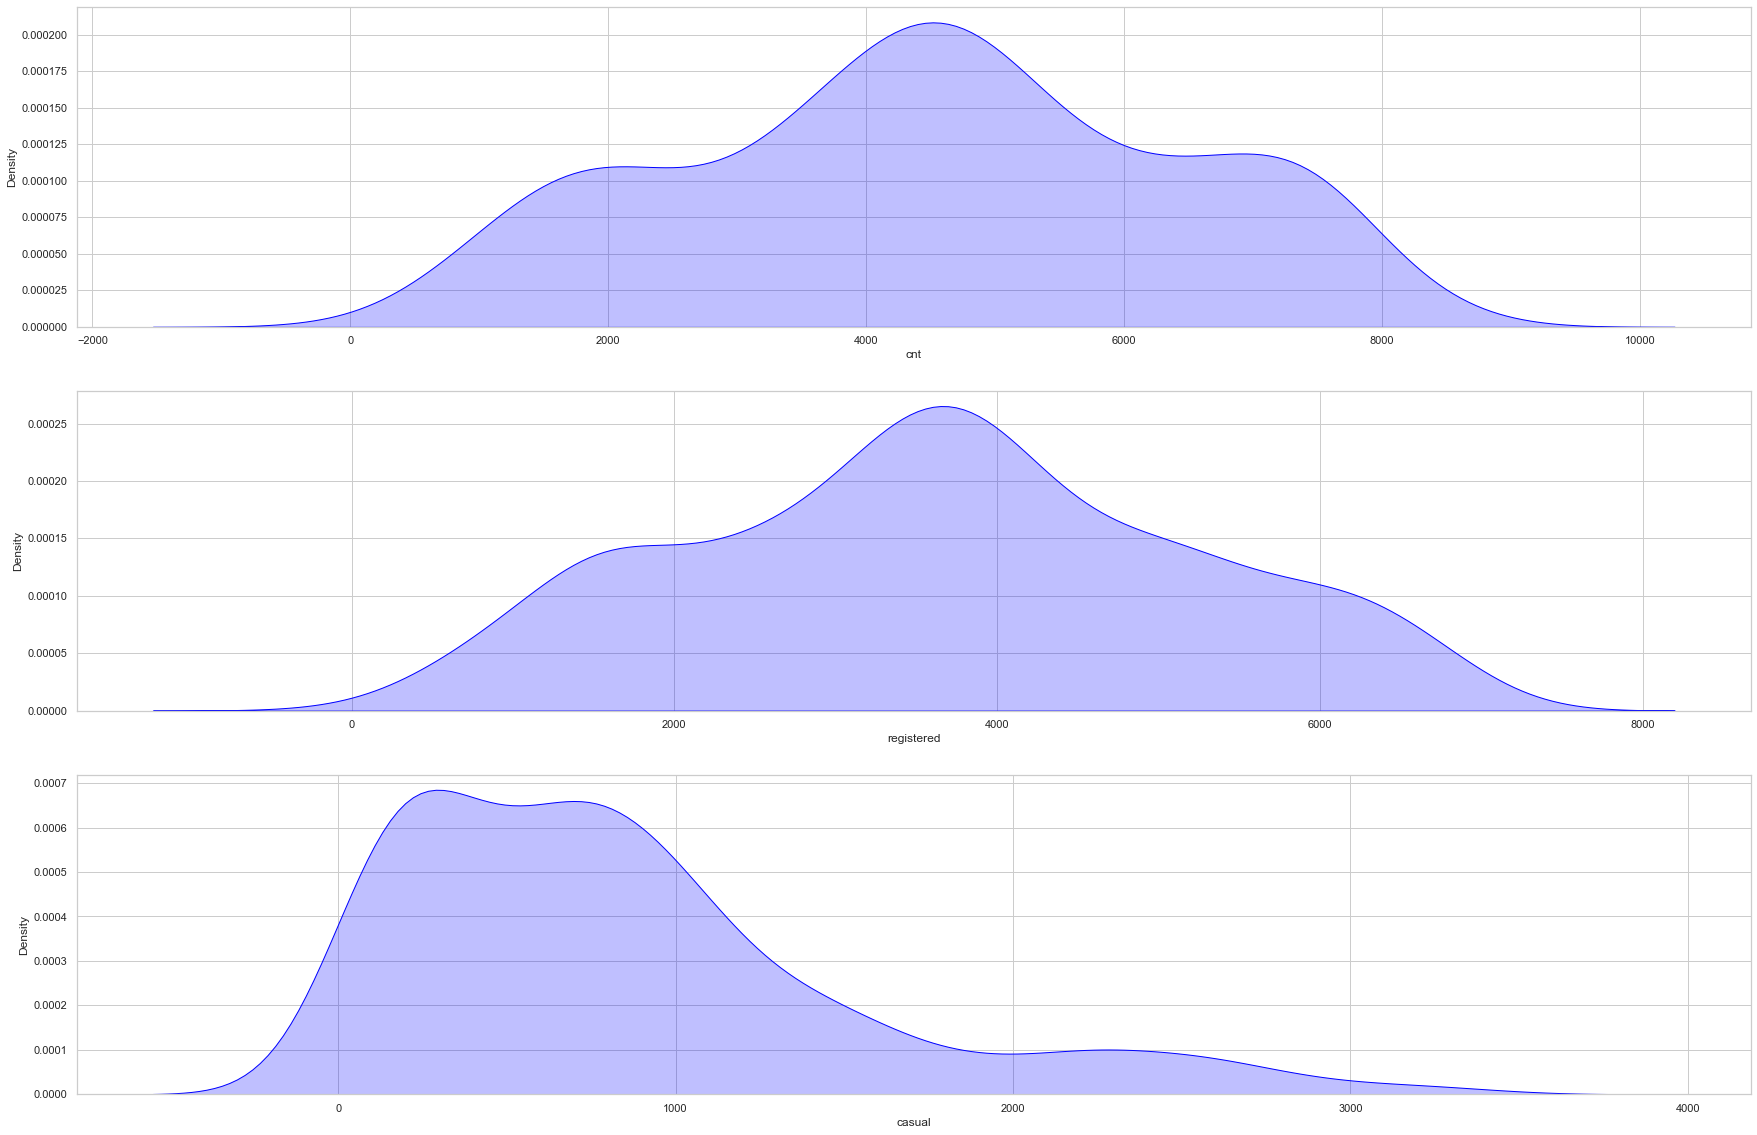

In [59]:
fig, axes= plt.subplots(3,1, figsize= (30, 20))
axes = axes.flat
sns.distplot(df_bike.cnt, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[0])
sns.distplot(df_bike.registered, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[1])
sns.distplot(df_bike.casual, hist=False, color="blue", kde_kws= {"shade": True, "linewidth":1},ax=axes[2]);
